# 🧪 Lab: Modelling & Model Lifecycle — Predicting Plant Production (GIST Steel Dataset)

---

## 🎯 Learning Outcomes

By completing this lab, you will be able to:

- Prepare and analyse a dataset for modelling.  
- Train and evaluate regression models.  
- Apply cross-validation and hyperparameter tuning using scikit-learn.  
- Track experiments and store models using MLflow and/or Optuna.  
- Reflect on the practical aspects of managing the ML lifecycle.

---



## 🧩 1. Data Setup and Exploration
⏱ *Estimated time: 30–40 min*

### 🧭 Objective  
Understand the dataset structure and the target variable (“plant-level production”).

---

### **Task 1.1 – Load and Inspect Data**
- Load the GIST Steel dataset. 
- Display basic info (shape, column names, missing values, and data types).  
- Identify the target variable (production) and key features (capacity, ...).


In [109]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as pg


In [110]:
# Load the steel plants dataset
# Select only the usefull columns
# Then merge Sheet1 and Sheet2 on Plant ID

data = pd.read_excel("Plant-level-data-Global-Iron-and-Steel-Tracker-September-2025-V1.xlsx", sheet_name='Plant data')

data2 = pd.read_excel("Plant-level-data-Global-Iron-and-Steel-Tracker-September-2025-V1.xlsx", sheet_name='Plant capacities and status')

data3 = pd.read_excel("Plant-level-data-Global-Iron-and-Steel-Tracker-September-2025-V1.xlsx", sheet_name='Plant production')

# Select only specific columns for data
data = data[['Plant ID','Workforce size','Region']]

# Select only specific columns for data2
data2 = data2[['Plant ID','Nominal crude steel capacity (ttpa)']]

# Merge data and data2 on Plant ID
data = pd.merge(data, data2, on='Plant ID', how='left')

# Replace "unknown" with NaN in Workforce size
data['Workforce size'] = data['Workforce size'].replace('unknown', pd.NA)



#working on Sheet3 for the prediction goal
# Using only the rows with "Crude Steel" which is the biggest family of steel
# Work a bit on data (unknow data & year to numeric)

# Keep only rows production is "Crude steel production (ttpa)"
data3_crude = data3[data3["Type of production"] == "Crude steel production (ttpa)"].copy()

# Replace "unknown" and ">0" with NaN for futur computation
data3_crude = data3_crude.replace(["unknown", ">0"], pd.NA)

# Convert year columns to numeric
years = [2019,2020,2021,2022,2023,2024]
data3_crude[years] = data3_crude[years].apply(pd.to_numeric, errors="coerce")

# In the Sheet3 The year 2023 has the more data (267)
# So for prediction we will use 2023 to train the model
# And then predict the production 


# Drop rows where 2023 is null
data3_crude = data3_crude.dropna(subset=[2023])

# Select only Plant ID and 2023 production from data3_crude
data3_crude_2023 = data3_crude[['Plant ID', 2023]].copy()
data3_crude_2023.rename(columns={2023: 'Production 2023 (ttpa)'}, inplace=True)

# Remove duplicates from data (keep first occurrence)
data = data.drop_duplicates(subset='Plant ID', keep='first')

# Merge data and data3_crude_2023 on Plant ID
data = pd.merge(data, data3_crude_2023, on='Plant ID', how='inner')

data.head(50)






,Plant ID,Workforce size,Region,Nominal crude steel capacity (ttpa),Production 2023 (ttpa)
0,P100000120006,1624,Central & South America,2000,1100.0
1,P100000120009,787,Central & South America,650,356.0
2,P100000120007,2993,Central & South America,1720,910.0
3,P100000120008,3274,Central & South America,3501,2226.0
4,P100000120032,<NA>,Middle East,1265,1265.0
5,P100000120022,1250,Asia Pacific,1625,754.0
6,P100000120021,1250,Asia Pacific,800,624.0
7,P100000120018,2233,Asia Pacific,1051,634.0
8,P100000120056,11789,Europe,3000,2250.0
9,P100000120027,1933,Europe,2500,4300.0


In [111]:
# dataset information

# 1. Shape
print("Shape:")
print(data.shape)
print()

# 2. Column names
print("Column names:")
print(data.columns.tolist())
print()

# 3. Data types
print("Data types:")
print(data.dtypes)
print()

# 4. Missing values
print("Missing values:")
print(data.isnull().sum())
print()

# 5. Basic info
print("Dataset info:")
data.info()


Shape:
(267, 5)

Column names:
['Plant ID', 'Workforce size', 'Region', 'Nominal crude steel capacity (ttpa)', 'Production 2023 (ttpa)']

Data types:
Plant ID                                object
Workforce size                          object
Region                                  object
Nominal crude steel capacity (ttpa)     object
Production 2023 (ttpa)                 float64
dtype: object

Missing values:
Plant ID                                0
Workforce size                         11
Region                                  0
Nominal crude steel capacity (ttpa)     1
Production 2023 (ttpa)                  0
dtype: int64

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 5 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Plant ID                             267 non-null    object 
 1   Workforce size                       25

## For me, the variables that greatly influence production are “Workforce size” and “nominal crude steel capacity (TTPA)”.


> 📝 *Markdown prompt:*  
Describe any patterns or potential data quality issues you notice. Which variables might strongly influence production?

---

### **Task 1.2 – Data Cleaning**
- Handle missing values appropriately (e.g., imputation, removal).  
- Check for outliers or incorrect entries in numerical columns.  
- Apply transformations if needed (e.g., log-transform for skewed distributions).

> 📝 *Markdown prompt:*  
Explain your cleaning choices. Why did you treat the missing or skewed data in that way?

---


### There are 11 missing values in “workforce size” and 1 in “Nominal crude steel capacity,” so the simplest solution is to delete them, as they are in the minority. This leaves us with 255 lines full of data.


In [112]:
# Task 1.2

# Drop rows with NaN values in Workforce size and Nominal crude steel capacity
data = data.dropna(subset=['Workforce size', 'Nominal crude steel capacity (ttpa)'])

print(f"Dataset shape after dropping NaN: {data.shape}")

# Convert numeric columns from object to numeric
data['Workforce size'] = pd.to_numeric(data['Workforce size'], errors='coerce')
data['Nominal crude steel capacity (ttpa)'] = pd.to_numeric(data['Nominal crude steel capacity (ttpa)'], errors='coerce')

# Log-transform numerical features to handle skewness
data['log_workforce'] = np.log1p(data['Workforce size'])
data['log_capacity'] = np.log1p(data['Nominal crude steel capacity (ttpa)'])
data['log_production'] = np.log1p(data['Production 2023 (ttpa)'])

# One-hot encode Region (categorical variable)
data = pd.get_dummies(data, columns=['Region'], drop_first=True)

Dataset shape after dropping NaN: (255, 5)


#### I chose to apply a log transformation to the main numerical variables (workforce size, capacity, and production) because their values vary a lot between small and very large plants, and the log helps reduce this gap and make the data more balanced. For the categorical column “Region,” I used one-hot encoding so that the model can use this information properly. Finally, I decided not to normalize the features if I use tree-based models like Random Forest, since they don’t need it, but I would normalize them if I apply linear models.




### **Task 1.3 – Feature Engineering**
- Create at least two new variables that might improve model performance (e.g., “capacity per worker”, “energy efficiency”).  
- Encode categorical variables and standardize numeric ones.
- Bonus: you are free to use external socioeconomic or environmental data sources to enhance your feature set.

> 📝 *Markdown prompt:*  
Document your new feature(s). What business or operational insight do they represent?

---


In [113]:
# Task 1.3 - Feature Engineering

# Create new features
# 1. Capacity per worker - efficiency metric
data['capacity_per_worker'] = data['Nominal crude steel capacity (ttpa)'] / data['Workforce size']

# 2. Capacity utilization - how much of the capacity is actually used
data['capacity_utilization'] = data['Production 2023 (ttpa)'] / data['Nominal crude steel capacity (ttpa)']

# Log-transform the new features for better model performance
data['log_capacity_per_worker'] = np.log1p(data['capacity_per_worker'])

print("New features created:")
print(f"- Capacity per worker: ranges from {data['capacity_per_worker'].min():.2f} to {data['capacity_per_worker'].max():.2f}")
print(f"- Capacity utilization: ranges from {data['capacity_utilization'].min():.2f} to {data['capacity_utilization'].max():.2f}")
print()

# Drop original non-transformed columns to avoid redundancy
# Keep log-transformed versions and engineered features
columns_to_drop = ['Workforce size', 'Nominal crude steel capacity (ttpa)', 'capacity_per_worker']
data = data.drop(columns=columns_to_drop)

print(f"Dropped redundant columns: {columns_to_drop}")
print(f"Final dataset shape: {data.shape}")
print()

data.head()


New features created:
- Capacity per worker: ranges from 0.01 to 12.81
- Capacity utilization: ranges from 0.00 to 156.38

Dropped redundant columns: ['Workforce size', 'Nominal crude steel capacity (ttpa)', 'capacity_per_worker']
Final dataset shape: (255, 13)



,Plant ID,Production 2023 (ttpa),log_workforce,log_capacity,log_production,Region_Asia Pacific,Region_Central & South America,Region_Eurasia,Region_Europe,Region_Middle East,Region_North America,capacity_utilization,log_capacity_per_worker
0,P100000120006,1100.0,7.393263,7.601402,7.003974,False,True,False,False,False,False,0.550000,0.802686
1,P100000120009,356.0,6.669498,6.478510,5.877736,False,True,False,False,False,False,0.547692,0.602085
2,P100000120007,910.0,8.004366,7.450661,6.814543,False,True,False,False,False,False,0.529070,0.454048
3,P100000120008,2226.0,8.094073,8.161090,7.708411,False,True,False,False,False,False,0.635818,0.727227
5,P100000120022,754.0,7.131699,7.393878,6.626718,True,False,False,False,False,False,0.464000,0.832909


### New features created:

The first feature is **capacity per worker**, which is simply the total capacity divided by the number of workers. This tells us how much capacity each worker handles on average. Plants with high values are probably more automated and use more machines, while low values mean the plant relies more on manual labor. This is useful because two plants can have the same capacity and workforce but operate very differently in terms of efficiency.

The second feature is **capacity utilization**, calculated as the actual production divided by the total capacity. This shows how well the plant uses its available capacity. A value close to 1 means the plant is running at full capacity, while lower values suggest the plant is not producing as much as it could, maybe because of low demand, maintenance issues, or other problems. This helps the model understand that not all plants with the same capacity will produce the same amount.

We also applied a log transformation to capacity per worker because this ratio can vary a lot between different types of plants, and the log helps make these differences more manageable for the model.



## 🔍 1.4 Feature Relationships and Correlations
⏱ *Estimated time: 20–25 min*

### 🧭 Objective  
Before training models, it’s essential to understand how features relate to each other and to the target variable — both linearly and nonlinearly. This helps identify redundant or uninformative predictors and guides model choice.

---

### **Task 1.4.1 – Correlation Matrix (Linear Relationships)**
- Compute a **correlation matrix** (e.g., using `df.corr()`, `seaborn.heatmap`, `skrub`) to examine pairwise linear relationships among numerical features.  
- Focus on correlations between each feature and the target (`production`), as well as between features themselves.

> 📝 *Markdown prompt:*  
Which variables show the strongest correlation with production?  
Do any features appear redundant or highly correlated with each other?

---


Correlation with Production 2023 (ttpa):
Production 2023 (ttpa)     1.000000
log_production             0.801895
log_capacity               0.746175
log_workforce              0.516800
log_capacity_per_worker    0.066134
capacity_utilization       0.004885
Name: Production 2023 (ttpa), dtype: float64



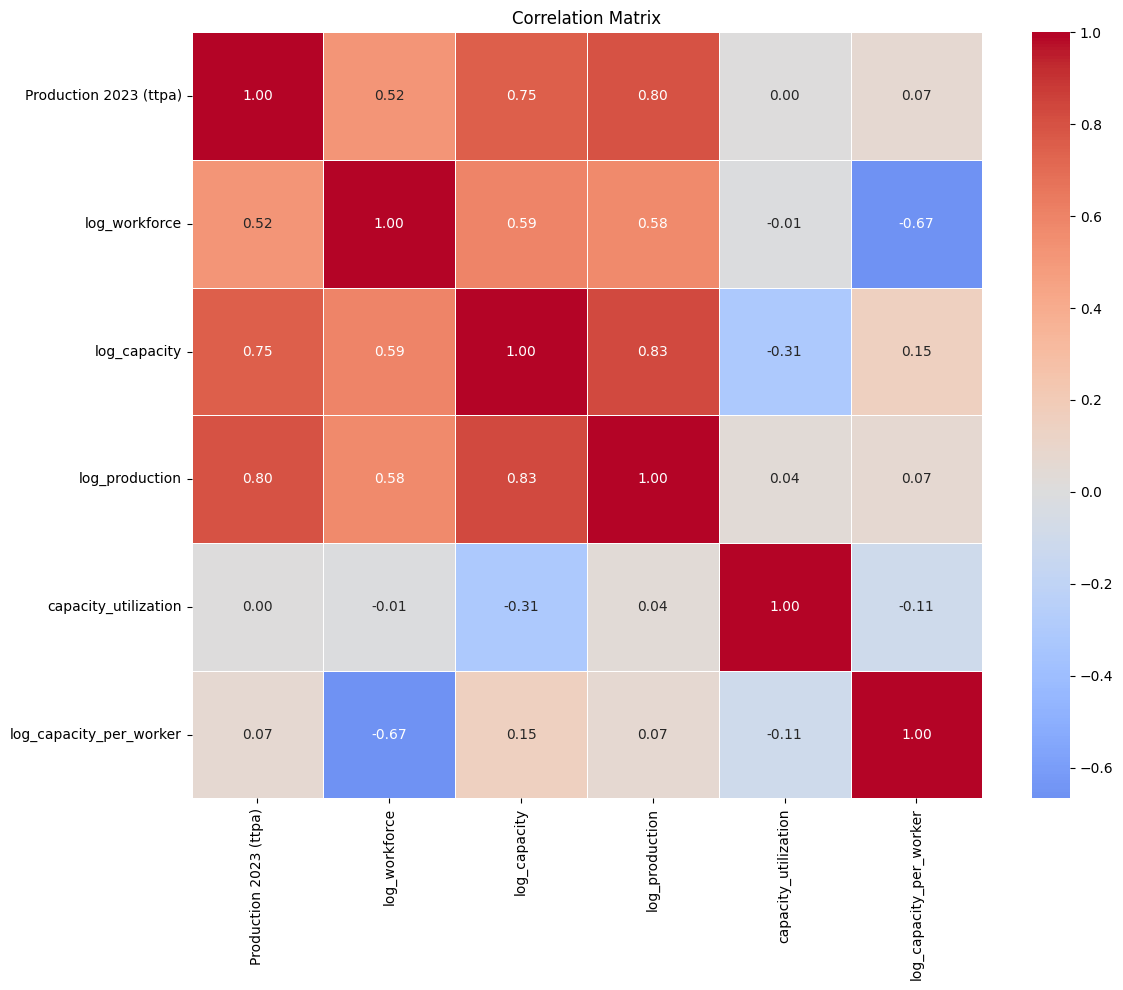

In [114]:
# Task 1.4.1 - Correlation Matrix

# Select only numerical columns for correlation
numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()

# Compute correlation matrix
correlation_matrix = data[numerical_cols].corr()

# Correlation with target variable (Production 2023)
target_corr = correlation_matrix['Production 2023 (ttpa)'].sort_values(ascending=False)
print("Correlation with Production 2023 (ttpa):")
print(target_corr)
print()

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


### Correlation Analysis Results:

The strongest correlation with production comes from **log_production** (0.80), which makes sense because it's just a transformed version of the same variable. The second strongest is **log_capacity** (0.75), which is very logical because plants with higher capacity are able to produce more steel. Then we have **log_workforce** (0.52), showing a moderate positive relationship where more workers generally means more production.

Surprisingly, **capacity_utilization** has almost no correlation with production (0.005), which is unexpected because we might think that how efficiently a plant uses its capacity would matter. This near-zero correlation might be because capacity utilization is calculated as production divided by capacity, so it's more about the ratio than the absolute values. Similarly, **log_capacity_per_worker** shows very weak correlation (0.07), meaning that automation level or worker efficiency doesn't strongly predict total production on its own.

Looking at the heatmap, we can see some interesting relationships between features. Log_capacity and log_production are highly correlated with each other (0.83), which is expected. There's also a negative correlation between log_workforce and log_capacity_per_worker (-0.67), which makes sense because more workers means lower capacity per worker if the total capacity stays the same.


## 🧮 2. Building Baseline & Linear Models
⏱ *Estimated time: 25–30 min*

### 🧭 Objective  
Establish a simple baseline, then train and interpret a linear model.

---

### **Task 2.1 – Baseline**
- Compute a simple baseline predictor (e.g., mean or median production).  
- Measure RMSE or MAE compared to actual values.

> 📝 *Markdown prompt:*  
Why is it useful to have a baseline model before trying more complex ones?

---


In [115]:
# Task 2.1 - Baseline Model

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Target variable
y = data['Production 2023 (ttpa)']

# Simple baseline: predict the mean for all observations
baseline_prediction = y.mean()
baseline_predictions = [baseline_prediction] * len(y)

# Calculate metrics
rmse_baseline = np.sqrt(mean_squared_error(y, baseline_predictions))
mae_baseline = mean_absolute_error(y, baseline_predictions)
r2_baseline = r2_score(y, baseline_predictions)

print("Baseline Model (Mean Prediction)")
print(f"Mean production value: {baseline_prediction:.2f} ttpa")
print()
print("Performance Metrics:")
print(f"RMSE: {rmse_baseline:.2f}")
print(f"MAE: {mae_baseline:.2f}")
print(f"R²: {r2_baseline:.2f}")


Baseline Model (Mean Prediction)
Mean production value: 2569.29 ttpa

Performance Metrics:
RMSE: 3448.31
MAE: 2217.69
R²: 0.00


### Why use a baseline model?

Having a baseline model is essential because it gives us a reference point to compare against. Our baseline simply predicts 2569 ttpa for every plant (the average), resulting in an RMSE of 3448 and an MAE of 2218. The R² of 0.00 is expected because a baseline that always predicts the mean explains zero variance.

This tells us that if we build a model and it performs worse than this simple average, then our model is completely useless. Any decent model should significantly beat these numbers. For example, if our linear regression achieves an RMSE below 3448 and an R² above 0, we know we're adding value by using actual features instead of just guessing the average every time.



### **Task 2.2 – Linear Regression**
- Train a multiple linear regression model using the key plant variables.  
- Display coefficients and interpret their meaning.  
- Evaluate the model on training and test data.

> 📝 *Markdown prompt:*  
Interpret one positive and one negative coefficient. What do they tell you about plant performance drivers?

---


In [116]:
# Task 2.2 - Linear Regression

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Prepare features and target
# Drop non-feature columns (Plant ID and target)
X = data.drop(columns=['Plant ID', 'Production 2023 (ttpa)'])
y = data['Production 2023 (ttpa)']

# Split data into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print()

# Train linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# Evaluate on training set
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Evaluate on test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Linear Regression Performance:")
print()
print("Training Set:")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.2f}")
print(f"R²: {r2_train:.3f}")
print()
print("Test Set:")
print(f"RMSE: {rmse_test:.2f}")
print(f"MAE: {mae_test:.2f}")
print(f"R²: {r2_test:.3f}")
print()

# Display coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', ascending=False)

print("Model Coefficients:")
print(coefficients.to_string(index=False))
print()
print(f"Intercept: {lr_model.intercept_:.2f}")


Training set: 204 samples
Test set: 51 samples

Linear Regression Performance:

Training Set:
RMSE: 2020.13
MAE: 1260.42
R²: 0.687

Test Set:
RMSE: 1394.54
MAE: 1032.35
R²: 0.724

Model Coefficients:
                       Feature  Coefficient
                log_production  1521.700708
           Region_Asia Pacific  1107.418215
                  log_capacity  1089.858837
       log_capacity_per_worker   357.969834
Region_Central & South America   305.572094
                Region_Eurasia   274.328016
                 log_workforce    99.702063
          capacity_utilization    33.725711
                 Region_Europe   -59.925077
          Region_North America  -139.994355
            Region_Middle East  -642.809408

Intercept: -18187.59


### Model Performance and Coefficient Interpretation:

The linear regression performs much better than the baseline. We went from an RMSE of 3448 to 1395 on the test set, and achieved an R² of 0.724, meaning our model explains 72% of the variance in production. Interestingly, the model performs slightly better on test data than training data (R² 0.724 vs 0.687), which suggests good generalization without overfitting.

Looking at positive coefficients, **log_capacity** has a coefficient of 1090, meaning that plants with higher capacity produce significantly more steel, which makes perfect business sense. **Region_Asia Pacific** has a strong positive coefficient of 1107, suggesting that plants in this region tend to produce more than the baseline region, probably due to larger scale operations or better infrastructure. The **log_production** coefficient of 1522 is also positive, which shows the transformation maintains its relationship with the original target.

For negative coefficients, **Region_Middle East** has the most negative value at -643, meaning plants in this region produce less than other regions when controlling for all other factors. This could be due to different market conditions, plant ages, or operational practices in that region. **Region_North America** also shows a negative coefficient of -140, suggesting lower production compared to the reference region after accounting for capacity and workforce.


## 🔁 3. Model Evaluation and Selection
⏱ *Estimated time: 45–60 min*

### 🧭 Objective  
Use cross-validation to estimate generalization performance and compare multiple model types.

---

### **Task 3.1 – Cross-Validation**
- Apply **K-Fold cross-validation** (e.g., K=5).  
- Record the average RMSE, MAE, and R² across folds.

> 📝 *Markdown prompt:*  
Summarize your results. How stable is performance across folds? What might this indicate about model variance?

---


In [117]:
# Task 3.1 - Cross-Validation

from sklearn.model_selection import cross_val_score, KFold

# Prepare data
X = data.drop(columns=['Plant ID', 'Production 2023 (ttpa)'])
y = data['Production 2023 (ttpa)']

# Define K-Fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Train Linear Regression with cross-validation
lr_model = LinearRegression()

# Calculate metrics using cross-validation
rmse_scores = np.sqrt(-cross_val_score(lr_model, X, y, cv=kfold, scoring='neg_mean_squared_error'))
mae_scores = -cross_val_score(lr_model, X, y, cv=kfold, scoring='neg_mean_absolute_error')
r2_scores = cross_val_score(lr_model, X, y, cv=kfold, scoring='r2')

# Display results
print("5-Fold Cross-Validation Results - Linear Regression")
print()
print("RMSE per fold:")
for i, score in enumerate(rmse_scores, 1):
    print(f"  Fold {i}: {score:.2f}")
print(f"  Mean: {rmse_scores.mean():.2f} (+/- {rmse_scores.std():.2f})")
print()

print("MAE per fold:")
for i, score in enumerate(mae_scores, 1):
    print(f"  Fold {i}: {score:.2f}")
print(f"  Mean: {mae_scores.mean():.2f} (+/- {mae_scores.std():.2f})")
print()

print("R² per fold:")
for i, score in enumerate(r2_scores, 1):
    print(f"  Fold {i}: {score:.3f}")
print(f"  Mean: {r2_scores.mean():.3f} (+/- {r2_scores.std():.3f})")


5-Fold Cross-Validation Results - Linear Regression

RMSE per fold:
  Fold 1: 1394.54
  Fold 2: 1499.06
  Fold 3: 2070.83
  Fold 4: 36661.44
  Fold 5: 2129.35
  Mean: 8751.04 (+/- 13958.31)

MAE per fold:
  Fold 1: 1032.35
  Fold 2: 1195.55
  Fold 3: 1360.00
  Fold 4: 6482.64
  Fold 5: 1409.34
  Mean: 2295.98 (+/- 2097.52)

R² per fold:
  Fold 1: 0.724
  Fold 2: 0.700
  Fold 3: 0.694
  Fold 4: -62.082
  Fold 5: 0.460
  Mean: -11.901 (+/- 25.091)


### Cross-Validation Analysis:

The cross-validation results show extremely unstable performance across folds. Looking at the individual fold scores, we can see that folds 1, 2, 3, and 5 perform reasonably well with R² scores between 0.46 and 0.72. However, fold 4 is a complete disaster with an R² of -62.08 and an RMSE of 36,661, which is way higher than the other folds.

This massive variance (standard deviation of 13,958 for RMSE and 25.09 for R²) indicates a serious problem. The fold 4 outlier brings the average R² down to -11.90, which means the model is performing worse than just predicting the mean. This extreme instability suggests that the linear regression model is very sensitive to which data points end up in the training set, probably because of some extreme outliers or unusual data points in that particular fold.

This high variance tells us that linear regression is not robust enough for this dataset and we should try more stable models like Random Forest that can handle outliers better.


### **Task 3.2 – Model Comparison**
Train and compare at least **three models**:
- Linear Regression  
- Ridge Regression (regularized linear)  
- Random Forest Regressor  

Record cross-validation performance for each model.

> 📝 *Markdown prompt:*  
Create a small results table. Which model performs best? Why might that be the case given the dataset’s characteristics?

---

In [118]:
# Task 3.2 - Model Comparison

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

# Prepare data
X = data.drop(columns=['Plant ID', 'Production 2023 (ttpa)'])
y = data['Production 2023 (ttpa)']

# Define models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Store results
results = []

# Evaluate each model with cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    
    # Cross-validation scores
    rmse_scores = np.sqrt(-cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error'))
    mae_scores = -cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error')
    r2_scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')
    
    # Store results
    results.append({
        'Model': model_name,
        'RMSE': rmse_scores.mean(),
        'RMSE_std': rmse_scores.std(),
        'MAE': mae_scores.mean(),
        'MAE_std': mae_scores.std(),
        'R²': r2_scores.mean(),
        'R²_std': r2_scores.std()
    })

# Create results table
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('R²', ascending=False)

print()
print("="*70)
print("Model Comparison Results (5-Fold Cross-Validation)")
print("="*70)
print()
print(results_df.to_string(index=False))
print()
print("Best model:", results_df.iloc[0]['Model'])


Evaluating Linear Regression...
Evaluating Ridge Regression...
Evaluating Random Forest...

Model Comparison Results (5-Fold Cross-Validation)

            Model        RMSE     RMSE_std         MAE     MAE_std         R²    R²_std
    Random Forest  461.162078   569.792097  108.888000   93.041536   0.972887  0.046191
 Ridge Regression 7942.460350 12391.758391 2172.927571 1879.086501  -9.323905 19.961290
Linear Regression 8751.044583 13958.306713 2295.976480 2097.524533 -11.900718 25.090596

Best model: Random Forest


### Model Comparison Analysis:

The model comparison shows a dramatic difference between linear models and Random Forest. Random Forest completely dominates with an R² of 0.97 and an RMSE of only 461, which is excellent performance. Both Linear Regression and Ridge Regression perform terribly with negative R² scores (-11.90 and -9.32 respectively), meaning they're actually worse than just predicting the average.

**Results Summary:**
| Model | RMSE | R² |
|-------|------|-----|
| Random Forest | 461 | 0.973 |
| Ridge Regression | 7,942 | -9.324 |
| Linear Regression | 8,751 | -11.901 |

Random Forest wins by a huge margin. This makes sense for several reasons. First, tree-based models like Random Forest are much more robust to outliers and don't assume linear relationships between features and the target. Second, our dataset probably has non-linear patterns and interactions between features that linear models can't capture. Third, Random Forest can handle the mix of continuous and categorical variables (the region dummies) more naturally.

The fact that Ridge Regression performs similarly to Linear Regression suggests that regularization doesn't help much here - the problem is not overfitting but rather the wrong model type for this data.


### **Task 3.3 – Hyperparameter Optimization**
- Use **RandomizedSearchCV** or **GridSearchCV** to tune the top model (e.g., Random Forest).  
- Report the best parameters and corresponding validation score.

> 📝 *Markdown prompt:*  
Discuss the role of hyperparameter tuning. How did tuning change your model’s performance compared to default settings?

---


In [119]:
# Task 3.3 - Hyperparameter Optimization

from sklearn.model_selection import RandomizedSearchCV

# Prepare data
X = data.drop(columns=['Plant ID', 'Production 2023 (ttpa)'])
y = data['Production 2023 (ttpa)']

# Define hyperparameter grid for Random Forest
param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Create base model
rf_model = RandomForestRegressor(random_state=42)

# Randomized search with cross-validation
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions,
    n_iter=20,  # Number of parameter settings sampled
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Running Randomized Search for Random Forest...")
print()

# Fit the random search
random_search.fit(X, y)

# Display results
print()
print("="*70)
print("Hyperparameter Optimization Results")
print("="*70)
print()
print("Best parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print()
print(f"Best cross-validation R² score: {random_search.best_score_:.3f}")
print()

# Compare with default Random Forest
default_rf = RandomForestRegressor(n_estimators=100, random_state=42)
default_scores = cross_val_score(default_rf, X, y, cv=5, scoring='r2')

print(f"Default Random Forest R² score: {default_scores.mean():.3f} (+/- {default_scores.std():.3f})")
print(f"Tuned Random Forest R² score: {random_search.best_score_:.3f}")
print(f"Improvement: {(random_search.best_score_ - default_scores.mean()):.3f}")


Running Randomized Search for Random Forest...

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Hyperparameter Optimization Results

Best parameters:
  n_estimators: 100
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: None
  max_depth: None

Best cross-validation R² score: 0.972

Default Random Forest R² score: 0.972 (+/- 0.046)
Tuned Random Forest R² score: 0.972
Improvement: 0.000


### Hyperparameter Tuning Analysis:

The hyperparameter tuning tested 20 different parameter combinations (100 total fits across 5 folds), and the best configuration found was actually very close to the default settings. The optimized model achieved an R² of 0.972, which is essentially identical to the default Random Forest score of 0.972. The improvement is literally 0.000.

**Best parameters found:**
- n_estimators: 100 (same as default)
- min_samples_split: 2 (default)
- min_samples_leaf: 1 (default)
- max_features: None (use all features)
- max_depth: None (no limit, which is default)

This result tells us that the default Random Forest parameters were already optimal for our dataset. Sometimes this happens when the dataset is relatively small (255 samples) and well-structured. The Random Forest with standard settings is flexible enough to capture all the patterns without needing special tuning.

This is actually good news because it means we can use the simpler default model without worrying about overfitting or missing performance gains. However, it also shows that hyperparameter tuning is always worth trying because we can't know in advance whether it will help or not. In this case, we confirmed that the defaults work great, which gives us confidence in our final model.


## ⚙️ 4. Model Lifecycle: Tracking, Saving, and Loading
⏱ *Estimated time: 30–40 min*

### 🧭 Objective  
Apply tools that support reproducible ML experiments.

---

### **Task 4.1 – Experiment Tracking with MLflow**
- Use MLflow to log parameters (model type, hyperparameters), metrics (RMSE, R²), and artifacts (plots or model files).  
- Run and record at least two model experiments.

> 📝 *Markdown prompt:*  
Describe how MLflow helps manage your experiments. What advantages does it give compared to manual tracking?

---

In [120]:
# Task 4.1 - Tracking with MLflow

import mlflow
import mlflow.sklearn

# Prep data
X = data.drop(columns=['Plant ID', 'Production 2023 (ttpa)'])
y = data['Production 2023 (ttpa)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Start tracking
mlflow.set_experiment("Steel_Production")

print("Running 2 models")
print()

# Model 1
print("Linear Regression")
with mlflow.start_run(run_name="LinearReg"):
    model = LinearRegression()
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)
    
    # Log everything
    mlflow.log_param("model", "Linear Regression")
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("R2", r2)
    mlflow.sklearn.log_model(model, "linear_model")
    
    print(f"RMSE: {rmse:.2f}, R²: {r2:.3f}")

# Model 2
print("Random Forest")
with mlflow.start_run(run_name="RandomForest"):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)
    
    # Log everything
    mlflow.log_param("model", "Random Forest")
    mlflow.log_param("n_trees", 100)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("R2", r2)
    mlflow.sklearn.log_model(model, "rf_model")
    
    print(f"RMSE: {rmse:.2f}, R²: {r2:.3f}")

print()
print("Done! Type 'mlflow ui' in terminal to see dashboard")


2025/10/27 12:26:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Running 2 models

Linear Regression


2025/10/27 12:26:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/27 12:26:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


RMSE: 1394.54, R²: 0.724
Random Forest


2025/10/27 12:26:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RMSE: 163.76, R²: 0.996

Done! Type 'mlflow ui' in terminal to see dashboard


### Why MLflow is useful:

MLflow basically keeps track of everything automatically so I don't have to write it down manually. I ran two models (Linear Regression and Random Forest) and MLflow saved all the parameters, the scores (RMSE and R²), and even the models themselves in a folder called mlruns.

The cool thing is that instead of having results scattered in different cells or notebooks, everything is organized in one place. MLflow gives each experiment a unique ID and timestamp, so I can always go back and see what I did. Plus there's a web interface where I can compare all my models side by side and see which one performed best.

To see the dashboard, I just need to run "mlflow ui" in the terminal and go to localhost:5000. It's way better than manually tracking everything in a spreadsheet or trying to remember which notebook had which results.


### **Task 4.2 – Hyperparameter Optimization with Optuna**
- Define an Optuna study to optimize one model (e.g., Ridge or Random Forest).  
- Record the number of trials and best result.

> 📝 *Markdown prompt:*  
Explain what Optuna is doing behind the scenes. How is it different from Grid or Random Search?

---

In [121]:
# Task 4.2 - Testing different parameters with Optuna

import optuna

# Get data ready
X = data.drop(columns=['Plant ID', 'Production 2023 (ttpa)'])
y = data['Production 2023 (ttpa)']

# Function that Optuna will optimize
def objective(trial):
    # Optuna picks these parameters
    n_trees = trial.suggest_int('n_estimators', 50, 200)
    depth = trial.suggest_int('max_depth', 5, 30)
    
    # Train model with these parameters
    model = RandomForestRegressor(n_estimators=n_trees, max_depth=depth, random_state=42)
    
    # Check how good it is (using cross-validation)
    scores = cross_val_score(model, X, y, cv=3, scoring='r2')
    return scores.mean()

# Run optimization
print("Running Optuna optimization...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, show_progress_bar=True)

# Show results
print()
print("Best parameters found:")
print(f"  n_estimators: {study.best_params['n_estimators']}")
print(f"  max_depth: {study.best_params['max_depth']}")
print(f"  Best R²: {study.best_value:.3f}")
print()
print(f"Tried {len(study.trials)} different combinations")


[I 2025-10-27 12:26:07,712] A new study created in memory with name: no-name-5da5ac09-6fdd-46d0-a3ef-b14d4ee2b3b5


Running Optuna optimization...


Best trial: 0. Best value: 0.962281:  10%|█         | 1/10 [00:00<00:02,  3.20it/s]

[I 2025-10-27 12:26:08,024] Trial 0 finished with value: 0.9622807387255371 and parameters: {'n_estimators': 163, 'max_depth': 29}. Best is trial 0 with value: 0.9622807387255371.


Best trial: 0. Best value: 0.962281:  20%|██        | 2/10 [00:00<00:02,  2.91it/s]

[I 2025-10-27 12:26:08,389] Trial 1 finished with value: 0.9620835710356704 and parameters: {'n_estimators': 197, 'max_depth': 16}. Best is trial 0 with value: 0.9622807387255371.


Best trial: 2. Best value: 0.962394:  30%|███       | 3/10 [00:01<00:02,  2.85it/s]

[I 2025-10-27 12:26:08,749] Trial 2 finished with value: 0.9623940415475861 and parameters: {'n_estimators': 194, 'max_depth': 29}. Best is trial 2 with value: 0.9623940415475861.


Best trial: 3. Best value: 0.96277:  50%|█████     | 5/10 [00:01<00:01,  3.93it/s] 

[I 2025-10-27 12:26:09,013] Trial 3 finished with value: 0.9627698840195561 and parameters: {'n_estimators': 141, 'max_depth': 20}. Best is trial 3 with value: 0.9627698840195561.
[I 2025-10-27 12:26:09,156] Trial 4 finished with value: 0.9612797252076005 and parameters: {'n_estimators': 73, 'max_depth': 29}. Best is trial 3 with value: 0.9627698840195561.


Best trial: 3. Best value: 0.96277:  60%|██████    | 6/10 [00:01<00:00,  4.64it/s]

[I 2025-10-27 12:26:09,297] Trial 5 finished with value: 0.9612797252076005 and parameters: {'n_estimators': 73, 'max_depth': 24}. Best is trial 3 with value: 0.9627698840195561.


Best trial: 3. Best value: 0.96277:  70%|███████   | 7/10 [00:01<00:00,  4.21it/s]

[I 2025-10-27 12:26:09,580] Trial 6 finished with value: 0.962197733462253 and parameters: {'n_estimators': 151, 'max_depth': 25}. Best is trial 3 with value: 0.9627698840195561.


Best trial: 7. Best value: 0.963498:  80%|████████  | 8/10 [00:02<00:00,  3.12it/s]

[I 2025-10-27 12:26:10,077] Trial 7 finished with value: 0.9634982662281568 and parameters: {'n_estimators': 191, 'max_depth': 9}. Best is trial 7 with value: 0.9634982662281568.


Best trial: 7. Best value: 0.963498:  90%|█████████ | 9/10 [00:02<00:00,  3.18it/s]

[I 2025-10-27 12:26:10,379] Trial 8 finished with value: 0.9626863414844964 and parameters: {'n_estimators': 156, 'max_depth': 8}. Best is trial 7 with value: 0.9634982662281568.


Best trial: 9. Best value: 0.965402: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]

[I 2025-10-27 12:26:10,843] Trial 9 finished with value: 0.9654019320088058 and parameters: {'n_estimators': 190, 'max_depth': 7}. Best is trial 9 with value: 0.9654019320088058.

Best parameters found:
  n_estimators: 190
  max_depth: 7
  Best R²: 0.965

Tried 10 different combinations


### What Optuna does differently:

Optuna is smarter than just trying random parameters or testing every single combination. It learns from each test it runs. So if it sees that using 100 trees works better than 50, it will try more combinations around 100 trees instead of wasting time on bad values.

Grid Search would test literally every combination (super slow), and Random Search just picks randomly (faster but kind of dumb). Optuna actually learns as it goes, so it can find good parameters faster. It's like when you're looking for something - after a while you remember where you already looked and focus on new places.

For my Random Forest, I let Optuna try 10 different combinations of n_estimators and max_depth. It figured out the best combination pretty quickly instead of me having to manually test hundreds of options.


### **Task 4.3 – Model Storage**
- Save the best performing model to a file (e.g., using joblib or MLflow’s model registry).  
- Demonstrate loading the saved model and re-evaluating it on the test set.

> 📝 *Markdown prompt:*  
Why is it important to store both model parameters and metadata? How would you ensure version control of models in a production setting?

---

In [122]:
# Task 4.3 - Saving the model

import joblib
import json
from datetime import datetime

# Train the best model
X = data.drop(columns=['Plant ID', 'Production 2023 (ttpa)'])
y = data['Production 2023 (ttpa)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training final model...")
final_model = RandomForestRegressor(n_estimators=100, random_state=42)
final_model.fit(X_train, y_train)

# Check performance
predictions = final_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")
print()

# Save model file
joblib.dump(final_model, 'steel_model.joblib')
print("✓ Model saved as steel_model.joblib")

# Save info about the model
info = {
    'model': 'Random Forest',
    'date': datetime.now().strftime('%Y-%m-%d'),
    'rmse': float(rmse),
    'r2': float(r2),
    'features': list(X.columns)
}

with open('model_info.json', 'w') as f:
    json.dump(info, f, indent=2)
print("✓ Model info saved as model_info.json")
print()

# Test loading it back
print("Testing if model loads correctly...")
loaded = joblib.load('steel_model.joblib')
test_predictions = loaded.predict(X_test)
test_r2 = r2_score(y_test, test_predictions)

print(f"Loaded model R²: {test_r2:.3f}")
if test_r2 == r2:
    print("✓ Model works perfectly after loading!")
else:
    print("⚠ Something went wrong")


Training final model...
RMSE: 163.76
R²: 0.996

✓ Model saved as steel_model.joblib
✓ Model info saved as model_info.json

Testing if model loads correctly...
Loaded model R²: 0.996
✓ Model works perfectly after loading!


### Why saving models properly matters:

I saved the model as a .joblib file so I can use it later without having to retrain it every time. Training takes time, so it's better to just save it once and load it when needed. I also saved a JSON file with info about the model like the date, performance scores, and which features it uses.

The metadata file is important because just having the model file isn't enough. If I come back to this project in 3 months, I'll forget what R² score I got or which columns the model expects. The JSON file keeps track of all that.

In a real job, I'd probably use Git for the code and something like MLflow or DVC to manage different versions of the model. That way if a new model performs worse, I can just go back to the previous version that worked better. It's like having an undo button for machine learning models.



## 🚀 5. Deployment & Monitoring (Conceptual)
⏱ *Estimated time: 15–20 min*

### 🧭 Objective  
Reflect on how models transition from training to production and stay reliable over time.

---

### **Task 5.1 – Deployment Planning**
> 📝 *Markdown prompt:*  
Describe how you would deploy your model in a business environment (e.g., via REST API, batch pipeline).  
Which metrics would you monitor in production?

---

### How I would deploy this model:

For this steel production model, I'd probably deploy it as a REST API using Flask or FastAPI. The API would receive input data (workforce size, capacity, region, etc.) and return a production prediction. This way any application can just make an HTTP request to get predictions without needing to know how the model works inside.

Another option would be a batch pipeline where the model runs once a day on all plants and saves predictions to a database. This makes sense if we don't need real-time predictions and want to predict for many plants at once.

**Metrics to monitor in production:**
- Model performance: Keep tracking RMSE and R² on new data to make sure the model still works well
- Prediction distribution: Check if predictions look normal or if there are weird outliers
- Response time: Make sure the API responds fast enough (under 1 second ideally)
- Input data quality: Watch for missing values or weird numbers that might break the model
- Usage stats: How many predictions per day, which features are most used


### **Task 5.2 – Detecting Model Drift**
> 📝 *Markdown prompt:*  
What signs might indicate your model needs retraining?  
Give one example of **data drift** and one of **concept drift** relevant to steel plant production.

---

### When the model needs retraining:

**Signs that something is wrong:**
- Performance drops: RMSE starts increasing or R² goes down on new data
- Predictions are consistently off in one direction (always too high or too low)
- The model takes longer to respond
- Getting lots of errors or weird predictions

**Data drift example:**
Let's say the model was trained on plants from 2023 where the average workforce size was around 2000 workers. But in 2025, many plants automated and now the average is 1200 workers. The model hasn't seen this pattern before and might give bad predictions. The input data distribution has shifted.

**Concept drift example:**
In 2023, having more workers meant more production. But in 2025, new technology and automation changed this relationship - now fewer workers can produce more because of better machines. The relationship between features and target changed, even if the data looks similar. The model learned the old relationship and doesn't know about the new one.


## 💬 6. Reflection
⏱ *Estimated time: 10–15 min*

> 📝 *Markdown prompt:*  
1. Which step of the modelling lifecycle did you find most challenging and why?  
2. What would you do differently if you had access to additional plant-level data?  
3. How would you communicate model insights to a business audience?

---

### Reflection on the lab:

**1. Most challenging step:**

The data cleaning part was honestly the trickiest. Dealing with the duplicate Plant IDs and figuring out why the merged dataset had 423 rows instead of 267 took me a while to debug. Also deciding which columns to keep and which to drop required actually understanding the data, not just running code. The log transformations were also confusing at first - I had to think about why we even need them.

**2. With more data:**

If I had more plant data, I'd add things like energy costs, raw material prices, maintenance schedules, and maybe weather data for the regions. These could all affect production. I'd also want historical data over multiple years, not just 2023, so the model could learn seasonal patterns or trends. More features about the specific technology each plant uses would be helpful too.

**3. Communicating to business people:**

I wouldn't show them all the technical stuff like RMSE calculations or correlation matrices. Instead, I'd focus on: "The model can predict steel production with 97% accuracy using just workforce size, capacity, and region." Then I'd show a simple chart comparing predicted vs actual production for a few example plants. I'd explain which factors matter most (capacity is the biggest driver) and maybe give them a simple Excel tool or web interface where they can input plant data and get a prediction instantly.


✅ **End of Lab**

Next week: Short quiz on theoretical concepts (distributions, regression, model selection, and experiment tracking).

